
# 주제 : 딥러닝으로 Seq2Seq 계산기 만들기
--------------
## 데이터 소개
    - 이번 주제는 직접 랜덤 생성한 Dataset을 사용.
    
    1. 학습 데이터 : train_text
      23 + 13
      1 - 3
      32 + 5
      1 + 62 ...
    
    2. 정답 데이터 : train_answer
      36
      -1
      37
      63 ...

## 최종 목표
    - Seq2Seq 기반 모델의 이해
    - word embedding 이해
    - 시계열 데이터 학습 이해

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## Step 1. 도입전 기본 처리

### 문제 1. 랜덤 2자리 더하기 데이터와 정답셋 생성

In [6]:
# 랜덤 2자리 더하기 데이터와 정답셋을 오만쌍 생성.
import random

def make_raw_text(count = 50000):
    train_text = []
    train_answer = []

    for _ in range(count):
        t = random.randint(0, 3)
        if t == 0:
            a = random.randint(0, 10)
        else:
            a = random.randint(0, 100)

        t = random.randint(0, 3)
        if t == 0:
            b = random.randint(0, 10)
        else:
            b = random.randint(0, 100)

        if random.randint(0, 2) == 0:
            train = f"{a} + {b}"
            answer = f"{a + b}"
        else:
            train = f"{a} - {b}"
            answer = f"{a - b}"

        train_text.append(train)
        train_answer.append(answer)
    return train_text, train_answer

train_text, train_answer = make_raw_text()

In [7]:
train_text[0], train_answer[0]

('23 - 63', '-40')

## Step 2. 전처리

### 문제 2. train_text, train_answer에서 나오는 모든 token을 map<token, id>형태로 변경



In [8]:
# train_text, train_answer에서 나오는 모든 token을 map<token, id>형태로 변경. (단, + -> 10, PAD -> 12, EOS -> 13)
# text2index
vocab = { str(i):i for i in range(10) }
vocab.update( { "+":10, "-":11, "PAD":12, "EOS":13} )
vocab

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '+': 10,
 '-': 11,
 'PAD': 12,
 'EOS': 13}

### 문제 3. vocab의 역형태인 map<id, token> 형태도 생성

In [9]:
# vocab의 역형태인 <id, token>을 생성.
# index2text
invocab = {v:k for k, v in vocab.items()}
invocab

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: '+',
 11: '-',
 12: 'PAD',
 13: 'EOS'}

### 문제 4. train_text와 train_answer를 BOW 형태로 변경

In [10]:
# train_text와 train_answer를 BOW 형태로 변경.
# BOW : 문서나 문장을 단어 집합으로 표현하여, 단어의 출현 빈도에만 집중하여 데이터 처리 가능
def plain2bow(text, vocab):
    return np.array([vocab[ch] for word in text.split() for ch in word] + [vocab['EOS']])

train_bow_text = [plain2bow(text, vocab) for text in train_text]
train_bow_answer = [plain2bow(text, vocab) for text in train_answer]

In [11]:
print(train_bow_text[0])
print(train_bow_text[1])
print(train_bow_text[2])

[ 2  3 11  6  3 13]
[ 2  3 11  0 13]
[ 9 10  9  9 13]


### 문제 5. train_bow_text와 train_bow_answer에 padding을 추가하여 완전한 np.array로 변경.

In [12]:
# train_bow_text와 train_bow_answer에 padding을 추가하여 완전한 np.array로 변경.
train_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_bow_text, value = vocab['PAD'])
train_bow_answer = tf.keras.preprocessing.sequence.pad_sequences(train_bow_answer, padding='post', value = vocab['PAD'])
    # padding='post' : 뒷부분에 padding / 'pre' : 앞부분에 패딩 <default>
    # text와 answer에서 padding의 위치를 다르게 설정한 이유
        # : text의 경우 뒷부분에 EOS가 있기 때문에 앞부분에 패딩
        # : answer의 경우 앞부분에 시작 토큰이 있기 때문에 뒷부분에 패딩

In [13]:
train_bow_text.shape, train_bow_answer.shape

((50000, 8), (50000, 5))

In [14]:
train_bow_text[0]

array([12, 12,  2,  3, 11,  6,  3, 13], dtype=int32)

### 문제 6. train_bow_text를 train_data_bow, test_data_bow로 (98%, 2%의 개수) 분리.

In [15]:
# train_bow_text를 train_bows, test_bows로 (98%, 2%의 개수) 분리.
def getSplit(data, rate):
    return int(len(data) * rate)

upper_bound = getSplit(train_bow_text, 0.98)

train_data_bow = train_bow_text[:upper_bound]
train_answer_bow = train_bow_answer[:upper_bound]

test_data_bow = train_bow_text[upper_bound:]
test_answer_bow = train_bow_answer[upper_bound:]

print(train_data_bow.shape, train_answer_bow.shape)
print(test_answer_bow.shape, test_answer_bow.shape)


(49000, 8) (49000, 5)
(1000, 5) (1000, 5)


## Step 3. 시각화 방법

### 문제 7. train_data_bow에서 등장하는 token의 분포 출력.

<BarContainer object of 14 artists>

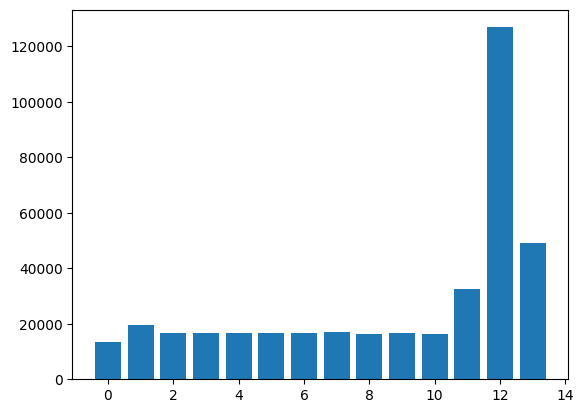

In [16]:
#  train_data_bow에서 등장하는 token의 분포를 출력.
digits, count = np.unique(train_data_bow, return_counts=True)
plt.bar(digits, count)

### 문제 8. train_answer_bow에서 등장하는 token의 분포 출력.

<BarContainer object of 13 artists>

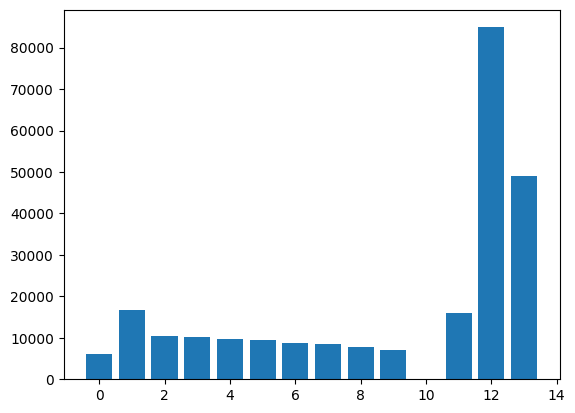

In [17]:
#  train_answer_bow에서 등장하는 token의 분포를 출력.
digits, count = np.unique(train_answer_bow, return_counts=True)
plt.bar(digits, count)

## Step 4. Seq2Seq용 입출력 보정

### 문제 9. train/test_answer_bow를 한쪽씩 당겨서 decoder에 주입시킬 데이터를 생성.

In [18]:
# train/test_answer_bow를 한쪽씩 당겨서 decoder에 주입시킬 데이터를 생성
# input data와 output data 간의 alignment를 시켜주는 것
# attention mechanism은 이 과정을 자동적으로 수행

train_shift_answer_bow =  np.concatenate([np.ones((train_answer_bow.shape[0], 1)) * vocab['PAD'], train_answer_bow[...,:-1]], axis=1)
# np.ones((train_answer_bow.shape[0], 1)) * vocab['PAD'] 과 train_answer_bow[...,:-1] 을 concatenate

test_shift_answer_bow =  np.concatenate([np.ones((test_answer_bow.shape[0], 1)) * vocab['PAD'], test_answer_bow[...,:-1]], axis=1)

print(train_shift_answer_bow.shape, test_shift_answer_bow.shape)

(49000, 5) (1000, 5)


In [19]:
train_answer_bow[...,:-1][0]

array([11,  4,  0, 13], dtype=int32)

In [20]:
train_answer_bow[0]

array([11,  4,  0, 13, 12], dtype=int32)

### 문제 10. 정답으로 처리될 train/test_answer_bow를 onehot 인코딩으로 바꾸기

In [21]:
# train/test_anser_bow를 onehot으로 변경
train_answer_onehot = tf.keras.utils.to_categorical(train_answer_bow, len(vocab))
test_answer_onehot = tf.keras.utils.to_categorical(test_answer_bow, len(vocab))
print(train_answer_onehot.shape, test_answer_onehot.shape)

(49000, 5, 14) (1000, 5, 14)


### 문제 11. data_bow, anser_bow, shift_answer_bow, onehot를 1개씩 출력.

In [22]:
# data_bow, shift_answer_bow, onehot, answer_bow등을 1개씩 출력.
print(train_data_bow[0], train_data_bow.shape)

print(train_shift_answer_bow[0], train_shift_answer_bow.shape)

print(train_answer_bow[0], train_answer_bow.shape)

print(train_answer_onehot[0], train_answer_onehot.shape)

[12 12  2  3 11  6  3 13] (49000, 8)
[12. 11.  4.  0. 13.] (49000, 5)
[11  4  0 13 12] (49000, 5)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]] (49000, 5, 14)


### 문제 12. onehot를 readable하게 바꿔주는 함수.

In [23]:
# onehot을 readable하게 바꿔주는 함수를 작성. (단, EOS는 .으로 PAD는 공백으로 전환)
# index2text에 해당하는 invocab을 활용

def onehot2text(onehot):
  return "".join(invocab[step.argmax()] for step in onehot).replace('EOS', '.').replace('PAD', '')

onehot2text(train_answer_onehot[0])

'-40.'

In [24]:
train_text[0]

'23 - 63'

### 문제 13. bow를 readable하게 바꿔주는 함수 작성.

In [25]:
# bow를 readable하게 바꿔주는 함수를 작성. (단, EOS는 .으로 PAD는 _으로 전환)
def bow2text(bow):
  return "".join(invocab[step] for step in bow).replace('EOS', '.').replace('PAD', '')

print(bow2text(train_data_bow[0]))
print(bow2text(train_shift_answer_bow[0]))
print(bow2text(train_answer_bow[0]))

23-63.
-40.
-40.


## Step 5. Seq2Seq 모델링

### 문제 14. Seq2Seq 모델 구축

In [26]:
# seq2seq 모델을 구축하고 학습모델, encoder, decoder를 구축
from keras.layers import Input, Embedding, GRU
from keras.models import Model

 #모델,  인코더, 디코더를 반환
def seq2seq():
  # 입력 시퀀스의 형태 정의
  inputs_x_bow = Input(shape=(8,))
  # embedding layer : 고정된 길이의 벡터 사용
  embedding = Embedding(len(vocab), 5)

  x = embedding(inputs_x_bow)
  z = GRU(16)(x)

  # 출력 시퀀스의 형태 정의
  inputs_y_bow = Input(shape=(5,))
  y = embedding(inputs_y_bow)
  gru = GRU(16, return_sequences=True) # 각 timestep에서의 출력값을 반

  y = gru(y, initial_state=z)   # encoder 반환값이 초기값으로 전달됨
  softmax = Dense(len(vocab), activation='softmax')

  y = softmax(y)
  model = Model([inputs_x_bow, inputs_y_bow], y)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

  encoder = Model(inputs_x_bow, z)

  inputs_y_dec = Input(shape=(1,))
  y2 = embedding(inputs_y_dec)

  inputs_z = Input(shape=(16,))
  h2 = gru(y2, initial_state=inputs_z)
  y2 = softmax(h2)

  decoder = Model([inputs_y_dec,inputs_z], [y2, h2])
  return model, encoder, decoder

### 문제 15. 학습 모델을 생성 후 summary 출력.

In [27]:
model, encoder, decoder = seq2seq()

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 embedding (Embedding)       multiple                     70        ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 gru (GRU)                   (None, 16)                   1104      ['embedding[0][0]']       

### 문제 16. encoder, decoder에 대한 summary 출력.

In [29]:
 # encoder, decoder에 대한 summary를 출력.
 encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 embedding (Embedding)       multiple                  70        
                                                                 
 gru (GRU)                   (None, 16)                1104      
                                                                 
Total params: 1174 (4.59 KB)
Trainable params: 1174 (4.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       multiple                     70        ['input_3[0][0]']             
                                                                                                  
 input_4 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 gru_1 (GRU)                 multiple                     1104      ['embedding[2][0]',           
                                                                     'input_4[0][0]']       

### 문제 17. 모델 학습 진행.

In [31]:
hist = model.fit( [train_data_bow, train_shift_answer_bow], train_answer_onehot,
          validation_data = ([test_data_bow, test_shift_answer_bow], test_answer_onehot), verbose=1, epochs=60
          )

Epoch 1/60
1532/1532 [==============================] - 22s 11ms/step - loss: 1.1855 - accuracy: 0.6027 - val_loss: 0.9432 - val_accuracy: 0.6600
Epoch 2/60
1532/1532 [==============================] - 14s 9ms/step - loss: 0.8845 - accuracy: 0.6732 - val_loss: 0.8395 - val_accuracy: 0.6780
Epoch 3/60
1532/1532 [==============================] - 13s 8ms/step - loss: 0.7926 - accuracy: 0.7116 - val_loss: 0.7357 - val_accuracy: 0.7370
Epoch 4/60
1532/1532 [==============================] - 11s 7ms/step - loss: 0.7026 - accuracy: 0.7537 - val_loss: 0.6677 - val_accuracy: 0.7612
Epoch 5/60
1532/1532 [==============================] - 13s 9ms/step - loss: 0.6385 - accuracy: 0.7774 - val_loss: 0.6059 - val_accuracy: 0.7798
Epoch 6/60
1532/1532 [==============================] - 13s 9ms/step - loss: 0.5911 - accuracy: 0.7930 - val_loss: 0.5622 - val_accuracy: 0.8004
Epoch 7/60
1532/1532 [==============================] - 13s 9ms/step - loss: 0.5542 - accuracy: 0.8036 - val_loss: 0.5317 - val_a

### 문제 18. 학습 진행 사항을 그래프로 출력.

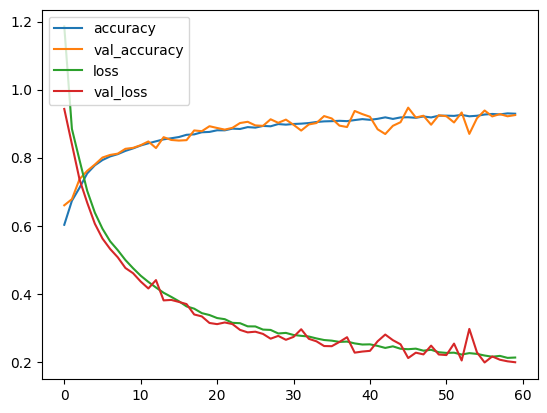

In [32]:
# hist의 accuracy와 loss를 plt의 plot을 이용하여 출력.
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

## Step 6. 모델 결과 확인

### 문제 19. plain2bow를 이용하여 encoder에 bow를 주입하고 z값 반환.

In [33]:
# plain2bow를 이용하여 encoder에 bow를 주입하고 z값 반환.
# plain2bow : bow 만드는 함수 (위에서 만듦)
bow = plain2bow("22 + 22", vocab)
bow = tf.keras.preprocessing.sequence.pad_sequences(bow[np.newaxis,:], value = vocab['PAD'], maxlen=8)
z = encoder(bow)

print(bow.shape, bow)

(1, 8) [[12 12  2  2 10  2  2 13]]


In [34]:
z # 11 + 11

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-0.9998148 ,  0.62034583,  0.9879061 , -0.9996784 , -0.5171136 ,
        -0.46279043,  0.9460055 ,  0.00254031,  0.9997138 , -0.99968845,
        -0.90803486,  0.9743581 ,  0.14447312, -0.99574333, -0.8668117 ,
        -0.9221613 ]], dtype=float32)>

In [35]:
z # 11 - 11

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-0.9998148 ,  0.62034583,  0.9879061 , -0.9996784 , -0.5171136 ,
        -0.46279043,  0.9460055 ,  0.00254031,  0.9997138 , -0.99968845,
        -0.90803486,  0.9743581 ,  0.14447312, -0.99574333, -0.8668117 ,
        -0.9221613 ]], dtype=float32)>

In [36]:
z # 22 + 22

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-0.9998148 ,  0.62034583,  0.9879061 , -0.9996784 , -0.5171136 ,
        -0.46279043,  0.9460055 ,  0.00254031,  0.9997138 , -0.99968845,
        -0.90803486,  0.9743581 ,  0.14447312, -0.99574333, -0.8668117 ,
        -0.9221613 ]], dtype=float32)>

### 문제 20. z와 PAD를 이용하여 첫번째 decoder 값 반환.

In [37]:
# z와 PAD를 이용하여 첫번째 decoder 값 반환.
init = np.array([vocab['PAD']])

b = np.array([[ 0.9073145 , -0.76238996, -0.44627753, -0.24877903, -0.7343119 ,
        -0.9685186 ,  0.5580055 ,  0.38927308,  0.12782967, -0.93181455,
         0.29033062, -0.83289367,  0.72241133, -0.827747  ,  0.5178557 ,
         0.99248517]])

first_pred, first_z = decoder([init, b])

print(first_z)

tf.Tensor(
[[[ 0.9072868  -0.11684718 -0.5518611   0.5069115   0.77272034
   -0.82595533  0.5601609   0.21435535  0.39962938 -0.92482555
    0.3556942  -0.8564311   0.71535313 -0.7961169   0.01272782
    0.9737838 ]]], shape=(1, 1, 16), dtype=float32)


In [38]:
print(first_pred)

tf.Tensor(
[[[2.9621768e-07 1.0233370e-05 2.6255026e-05 1.2057907e-08 6.8378494e-09
   1.3261372e-06 1.3441994e-09 2.5080830e-13 9.3613431e-13 4.8843811e-11
   3.6200331e-07 2.7399182e-13 2.3811813e-02 9.7614974e-01]]], shape=(1, 1, 14), dtype=float32)


### 문제 21. first_pred에 값이 가장 큰 index를 이용하여 문자로 decoding.

In [39]:
# first_pred에 값이 가장 큰 index를 이용하여 문자로 decoding.
first_pred.numpy().argmax()

13

### 문제 22. first_z와 first_pred를 이용해서 second_pred를 획득하고 문자로 decoding.

In [40]:
# irst_z와 first_pred를 이용해서 second_pred를 획득하고 문자로 decoding.
second_pred, second_z = decoder([ np.array([first_pred.numpy().argmax()]), first_z[0] ] )

In [41]:
print(second_pred)

tf.Tensor(
[[[3.9004858e-12 6.7232704e-12 8.6313939e-10 2.1283116e-12 1.0980642e-10
   7.5166774e-08 4.7500785e-11 3.3655804e-15 1.2695215e-15 1.5325859e-15
   8.0596579e-10 6.9972846e-16 9.9975997e-01 2.3995941e-04]]], shape=(1, 1, 14), dtype=float32)


In [42]:
second_z

<tf.Tensor: shape=(1, 1, 16), dtype=float32, numpy=
array([[[ 0.90728045,  0.05961105, -0.96684   ,  0.8161182 ,
          0.9669784 , -0.8366897 ,  0.56020033,  0.2790067 ,
          0.92688614, -0.5271639 ,  0.37514427, -0.89346135,
          0.71534824, -0.79413027,  0.3759191 ,  0.9644967 ]]],
      dtype=float32)>

In [43]:
invocab[second_pred.numpy().argmax()]

'PAD'

In [44]:
a, b = decoder([ np.array([second_pred.numpy().argmax()]), second_z[0] ] )

In [45]:
a

<tf.Tensor: shape=(1, 1, 14), dtype=float32, numpy=
array([[[9.6213856e-11, 1.3462584e-10, 1.3501266e-09, 1.5858128e-12,
         2.0760829e-09, 2.8658418e-05, 2.6150321e-08, 1.6956204e-12,
         1.8357954e-13, 3.7228166e-13, 3.0576963e-08, 9.7036596e-14,
         9.9991953e-01, 5.1778607e-05]]], dtype=float32)>

In [46]:
b

<tf.Tensor: shape=(1, 1, 16), dtype=float32, numpy=
array([[[ 0.9072784 ,  0.46284196, -0.97256804,  0.8627256 ,
          0.97512996, -0.82355034,  0.56101805,  0.05810761,
          0.98342717, -0.5240168 ,  0.38435134, -0.9046539 ,
          0.7146228 , -0.79105467, -0.20230892,  0.9623543 ]]],
      dtype=float32)>

In [47]:
invocab[a.numpy().argmax()]

'PAD'

### 문제 23. 입력 text가 주어지면 bow로 바꾼뒤 pad가 나올 때까지 문자를 decoding하는 함수 작성.


In [48]:
def decoding(text):
  bow = plain2bow(text, vocab)
  bow = tf.keras.preprocessing.sequence.pad_sequences(bow[np.newaxis,:], value = vocab['PAD'], maxlen=8)

  z = encoder(bow)
  word_vec = np.array([vocab['PAD']])

  res = []
  while True:
    word_vec, z = decoder([word_vec, z])
    word = invocab[word_vec.numpy().argmax()]

    if word in ['EOS', 'PAD']: break
    res.append(word)

    word_vec = np.array([word_vec.numpy().argmax()])
    z = z[0]

  answer = "".join(res)
  print( f"{text} = {answer}")
  return answer


### 문제 24. decoding으로 몇가지 산술 연산 테스트.

In [49]:
decoding("15 + 6")

15 + 6 = 20


'20'

### 문제 25. 모델 평가

In [50]:
model.evaluate([test_data_bow, test_shift_answer_bow], test_answer_onehot, verbose=1)

32/32 [==============================] - 0s 4ms/step - loss: 0.1987 - accuracy: 0.9252


[0.19874998927116394, 0.9251999855041504]

## Step 7. 모델 저장 및 로드, 다운

### 문제 26. 모델 저장.

In [51]:
model.save('./lecture009.h5')
encoder.save('./lecture009-encoder.h5')

### 문제 27. 모델 파일을 새로운 모델에 로드.

In [52]:
new_model = tf.keras.models.load_model('./lecture009.h5')

### 문제 28. 로드한 모델을 test 데이터로 평가.


In [53]:
new_model.evaluate([test_data_bow, test_shift_answer_bow], test_answer_onehot, verbose=1)

32/32 [==============================] - 1s 4ms/step - loss: 0.1987 - accuracy: 0.9252


[0.19874998927116394, 0.9251999855041504]

### 문제 29. 모델을 내 컴퓨터에 저장

In [54]:
# 모델을 내 컴퓨터에 저장.
from google.colab import files
files.download('./lecture009.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>